In [75]:
from datetime import datetime
import os
import csv
import pandas as pd
from datetime import datetime, timedelta

from math import pi, asin, sqrt, cos, sin
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [71]:
def completa_secondi(secondo):
    if '.' not in secondo:
        secondo = secondo+'.0000'
    else:
        secondo = secondo.split('.')
        n = len(secondo[1])
        for i in range(4-n):
            secondo[1] += '0'
        secondo = secondo[0]+'.'+secondo[1]
    return secondo

def OraLegale_and_UTC(stamp):
    giornoora = stamp
    #giorno = datetime.strptime(giorno,'%Y-%m-%d')
    #ora = datetime.strptime(ora,'%H:%M:%S.%f')
    giornoora = datetime.strptime(giornoora,'%Y-%m-%d %H:%M:%S')
    if giornoora>=datetime.strptime('2018-03-25 02:00:00','%Y-%m-%d %H:%M:%S')\
         and giornoora<=datetime.strptime('2018-10-28 03:00:00','%Y-%m-%d %H:%M:%S'):
        delta = timedelta(seconds=3600)
    else:
        delta = timedelta(seconds=7200)
    return giornoora + delta

def earth_distance(lat_lng1, lat_lng2):  # da notebook master big data
    if not lat_lng1[0] or lat_lng2[0]==255:
        return ''
    try:
        lat1, lng1 = [float(l)*pi/180 for l in lat_lng1]
        lat2, lng2 = [float(l)*pi/180 for l in lat_lng2]
        dlat, dlng = lat1-lat2, lng1-lng2
        ds = 2 * asin(sqrt(sin(dlat/2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlng/2.0) ** 2))
        return 6371.01 * ds  # spherical earth...
    except Exception as e:
        print(e)
        return

In [48]:
trips = pd.read_csv('C:\\Users\leuci\Desktop\Test_Preprocessing\TRIP_dopoAgosto.csv', delimiter=';')

trips['voucher'] = trips['voucher'].astype('str')

trips_grouped = trips.groupby('voucher') # non raggruppare per data, i trip possono accavallarsi tra più giorni

sinistri_con_trip = []

sinistriTrip = pd.DataFrame()

with open('C:\\Users\leuci\Desktop\Test_Preprocessing\sinistri2crash_MOD_MANUALE_TEMP.csv', 'r') as fin:
    sinistri = csv.reader(fin, delimiter=';')
    next(sinistri, None)
    for sinistro in sinistri:
        print(sinistro[0], sinistro[1])
        devices = sinistro[0] # deviceSinistro
        #orac = sinistro[8].split('\\')[-1].split('_')
        datac = sinistro[1] # la stessa del sinistro
        orac = sinistro[7]
        datetimec = datac+' '+orac
        datetimec = datetime.strptime(datetimec, '%d/%m/%Y %H:%M:%S') #datetimeCrash
        try:
            g = trips_grouped.get_group(devices)

            trip_assegnato = False

            # crea liste per scorrere tra i trip
            startts = list(g['startTime']) #startTrip(s=lista di tutti gli startTrip)
            endts = list(g['endTime'])
            latts = list(g['endLat'])
            lonts = list(g['endLon'])

            for startt,endt,latt,lont in zip(startts,endts,latts,lonts):
                startt = OraLegale_and_UTC(startt.strip('Z'))
                endt = OraLegale_and_UTC(endt.strip('Z'))
                if startt<=datetimec and endt>=datetimec:  # se crash appartiene al trip
                    l = sinistro+[startt,endt,latt,lont]
                    print(datetimec, startt, endt)
                    #print(startt,endt,latt,lont)
                    sinistri_con_trip.append(l)
                    trip_assegnato = True
            if not trip_assegnato:  # se non trova nessun trip per quel crash
                l = sinistro+[None,'','','']
                #sinistri_con_trip.append(l)
        except Exception as e:
            print(e, devices)
            continue 
columns = [
    'device',
    'dataSinistro',
    'oraSinistro',
    'luogoSinistro',
    'provinciaSinistro',
    'latSinistro',
    'lonSinistro',
    'oraCrash',
    'filePOS',
    'fileACC',
    'latCrash',
    'lonCrash',
    'tipoAbbinamento',
    'distanza_km',
    # aggiunte in questo nb
    'NULL1','NULL2','NULL3',
    'startTrip',
    'endTrip',
    'endLat',
    'endLon'
]


248203 07/05/2018
'248203' 248203
251376 01/05/2018
265948 03/03/2018
244737 28/04/2018
270035 11/05/2018
264721 18/02/2018
256689 20/05/2018
264628 11/04/2018
266650 24/02/2018
253778 05/03/2018
270370 18/02/2018
267639 13/10/2018
2018-10-13 15:52:58 2018-10-13 14:57:32 2018-10-13 16:08:28
265084 25/07/2018
'265084' 265084
264721 21/07/2018
263910 19/07/2018
268527 21/03/2018
269917 15/03/2018
252149 07/09/2018
2018-09-07 01:03:40 2018-09-07 01:02:40 2018-09-07 01:07:06
267637 07/03/2018
251373 30/03/2018
264520 02/03/2018
270030 09/03/2018
265077 22/03/2018
270033 04/03/2018
262815 11/03/2018
252147 14/04/2018
'252147' 252147
262810 18/03/2018
278357 28/10/2018
2018-10-28 17:49:19 2018-10-28 17:36:46 2018-10-28 18:22:36
248199 17/03/2018
268527 11/05/2018
263904 08/03/2018
248264 12/04/2018
249440 19/05/2018
268524 03/04/2018
264629 09/04/2018
265943 16/05/2018
'265943' 265943
269354 13/08/2018
251373 11/09/2018
2018-09-11 06:48:09 2018-09-11 06:31:24 2018-09-11 06:53:56
266644 17/02

In [72]:
sinistriTrip = pd.DataFrame(sinistri_con_trip, columns = columns)
sinistriTrip['distanza_crash_sinistro'] = sinistriTrip['distanza_km']
del sinistriTrip['NULL1']
del sinistriTrip['NULL2']
del sinistriTrip['NULL3']

#sinistriTrip['distanza_startTrip_crash'] = sinistriTrip.apply(lambda r:
#                                        earth_distance((r['latCrash'].replace(',','.'),
#                                                        r['lonCrash'].replace(',','.')),
#                                                       (r['startLat'],
#                                                        r['startLon']))          
#                                                  , axis=1)

sinistriTrip['distanza_endTrip_crash'] = sinistriTrip.apply(lambda r:
                                        earth_distance((r['latCrash'].replace(',','.'),
                                                        r['lonCrash'].replace(',','.')),
                                                       (r['endLat'],
                                                        r['endLon']))          
                                                  , axis=1)

sinistriTrip.head()

,device,dataSinistro,oraSinistro,luogoSinistro,provinciaSinistro,latSinistro,lonSinistro,oraCrash,filePOS,fileACC,latCrash,lonCrash,tipoAbbinamento,distanza_km,startTrip,endTrip,endLat,endLon,distanza_crash_sinistro,distanza_endTrip_crash
0,267639,13/10/2018,17:06,VIA DIOOMEDE,MI,4.548.362,913.438,15:52:58,D:\Master\Blob2csv\POS\2018_10_13 14_52_58_564...,D:\Master\Blob2csv\ACC\2018_10_13 14_52_58_564...,"45,47899","9,14035",intorno4ore,"0,694038882",2018-10-13 14:57:32,2018-10-13 16:08:28,45.47899,9.14035,"0,694038882",0
1,252149,07/09/2018,02:00,VIA CANONICA,MI,4.547.833,91.757,01:03:40,D:\Master\Blob2csv\POS\2018_09_07 00_03_40_530...,D:\Master\Blob2csv\ACC\2018_09_07 00_03_40_530...,"45,47757667","9,180536667",intorno4ore,"0,386297741",2018-09-07 01:02:40,2018-09-07 01:07:06,255.00000,255.00000,"0,386297741",
2,278357,28/10/2018,17:00,PZZALE CANTORE,MI,454.562,917.258,17:49:19,D:\Master\Blob2csv\POS\2018_10_28_15_52_33_577...,D:\Master\Blob2csv\ACC\2018_10_28_15_52_33_577...,"45,45574","9,17342",intorno4ore,"0,083120473",2018-10-28 17:36:46,2018-10-28 18:22:36,45.45566,9.17353,"0,083120473",0.0123591
3,251373,11/09/2018,00:00,IGNOTA,MI,,,06:48:09,D:\Master\Blob2csv\POS\2018_09_11 05_48_09_533...,D:\Master\Blob2csv\ACC\2018_09_11 05_48_09_533...,"45,49004","9,20827",piu_alto,,2018-09-11 06:31:24,2018-09-11 06:53:56,45.49084,9.20688,,0.14019
4,270038,03/08/2018,00:00,MILANO,MI,,,04:07:30,D:\Master\Blob2csv\POS\2018_08_03 03_07_30_499...,D:\Master\Blob2csv\ACC\2018_08_03 03_07_30_499...,"45,47227","9,16751",piu_alto,,2018-08-03 04:03:14,2018-08-03 04:10:01,45.47226,9.16751,,0.00111195


In [73]:
sinistriTrip

,device,dataSinistro,oraSinistro,luogoSinistro,provinciaSinistro,latSinistro,lonSinistro,oraCrash,filePOS,fileACC,latCrash,lonCrash,tipoAbbinamento,distanza_km,startTrip,endTrip,endLat,endLon,distanza_crash_sinistro,distanza_endTrip_crash
0,267639,13/10/2018,17:06,VIA DIOOMEDE,MI,4.548.362,913.438,15:52:58,D:\Master\Blob2csv\POS\2018_10_13 14_52_58_564...,D:\Master\Blob2csv\ACC\2018_10_13 14_52_58_564...,"45,47899","9,14035",intorno4ore,"0,694038882",2018-10-13 14:57:32,2018-10-13 16:08:28,45.47899,9.14035,"0,694038882",0
1,252149,07/09/2018,02:00,VIA CANONICA,MI,4.547.833,91.757,01:03:40,D:\Master\Blob2csv\POS\2018_09_07 00_03_40_530...,D:\Master\Blob2csv\ACC\2018_09_07 00_03_40_530...,"45,47757667","9,180536667",intorno4ore,"0,386297741",2018-09-07 01:02:40,2018-09-07 01:07:06,255.00000,255.00000,"0,386297741",
2,278357,28/10/2018,17:00,PZZALE CANTORE,MI,454.562,917.258,17:49:19,D:\Master\Blob2csv\POS\2018_10_28_15_52_33_577...,D:\Master\Blob2csv\ACC\2018_10_28_15_52_33_577...,"45,45574","9,17342",intorno4ore,"0,083120473",2018-10-28 17:36:46,2018-10-28 18:22:36,45.45566,9.17353,"0,083120473",0.0123591
3,251373,11/09/2018,00:00,IGNOTA,MI,,,06:48:09,D:\Master\Blob2csv\POS\2018_09_11 05_48_09_533...,D:\Master\Blob2csv\ACC\2018_09_11 05_48_09_533...,"45,49004","9,20827",piu_alto,,2018-09-11 06:31:24,2018-09-11 06:53:56,45.49084,9.20688,,0.14019
4,270038,03/08/2018,00:00,MILANO,MI,,,04:07:30,D:\Master\Blob2csv\POS\2018_08_03 03_07_30_499...,D:\Master\Blob2csv\ACC\2018_08_03 03_07_30_499...,"45,47227","9,16751",piu_alto,,2018-08-03 04:03:14,2018-08-03 04:10:01,45.47226,9.16751,,0.00111195
5,265941,05/08/2018,00:00,,MI,,,12:32:53,D:\Master\Blob2csv\POS\2018_08_05 11_32_53_501...,D:\Master\Blob2csv\ACC\2018_08_05 11_32_53_501...,"45,48607","9,14459",piu_alto,,2018-08-05 11:56:28,2018-08-05 12:35:28,45.48618,9.14446,,0.0158844
6,257297,29/08/2018,00:00,,MI,,,20:00:23,D:\Master\Blob2csv\POS\2018_08_28 23_00_34_521...,D:\Master\Blob2csv\ACC\2018_08_28 23_00_34_521...,"45,45253","9,20151",piu_alto,,2018-08-29 19:58:20,2018-08-29 21:10:25,45.46812,9.20698,,1.78526
7,270371,06/09/2018,00:00,,MI,,,14:17:03,D:\Master\Blob2csv\POS\2018_09_06 13_17_03_529...,D:\Master\Blob2csv\ACC\2018_09_06 13_17_03_529...,"45,46813","9,17762",piu_alto,,2018-09-06 14:03:43,2018-09-06 14:20:00,45.46980,9.17677,,0.197171
8,268523,09/09/2018,00:00,,MI,,,04:23:36,D:\Master\Blob2csv\POS\2018_09_09 03_23_36_532...,D:\Master\Blob2csv\ACC\2018_09_09 03_23_36_532...,"45,44064","9,16337",piu_alto,,2018-09-09 04:12:02,2018-09-09 04:27:13,255.00000,255.00000,,
9,268691,21/09/2018,00:00,,MI,,,22:33:54,D:\Master\Blob2csv\POS\2018_09_21 19_51_47_544...,D:\Master\Blob2csv\ACC\2018_09_21 19_51_47_544...,"45,43743","9,17884",piu_alto,,2018-09-21 22:24:45,2018-09-21 22:37:52,45.45201,9.19311,,1.96665


### Studio distanza endTrip e crash

Text(0,0.5,'count')

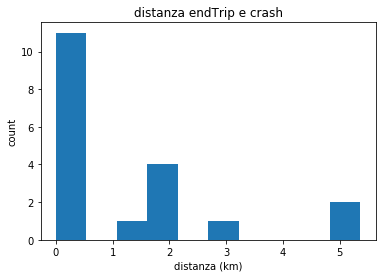

In [83]:
plt.hist([e for e in list(sinistriTrip['distanza_endTrip_crash']) if e])
plt.title('distanza endTrip e crash')
plt.xlabel('distanza (km)')
plt.ylabel('count')

In [91]:
dist = [e for e in list(sinistriTrip['distanza_endTrip_crash']) if e]
dist1km = [e for e in dist if float(e)<=0.2]
print(len(dist))
print(len(dist1km)/len(dist))

19
0.5789473684210527


In [92]:
np.mean(dist)

1.185987198894751